# Text classifcation - transfer learning

https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

In [16]:
import pandas as pd
import numpy as np
import re
import tweepy
import urllib.request
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import os
import string  
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image, ImageFont
import math
from fa2 import ForceAtlas2
import community
import warnings
warnings.filterwarnings("ignore")

from ast import literal_eval


from fastai import *
from fastai.text import *
from pathlib import Path
import re

import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.4.1


In [18]:
import torch
!pip install pyyaml h5py  # Required to save models in HDF5 format
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)


Cuda available
PyTorch version:  1.8.1+cu101


In [3]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:

link ="https://drive.google.com/file/d/1uALKWXbpw7oIBzrdy5QomE0iP2EeLkdj/view?usp=sharing"

id = link.split('/')[5]
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df_clas = pd.read_csv('Filename.csv')

df_clas = df_clas[df_clas['tokens'].notna()].reset_index(drop=True)

#df = pd.read_csv('../Flood_data/labelled/final_labelled_tweets.csv')
df_clas['tokens'] = [literal_eval(s) for s in df_clas['tokens'] if s!=np.nan]

df_clas.head()

1uALKWXbpw7oIBzrdy5QomE0iP2EeLkdj


,tweet_id,full_text,tokens,relevant
0,295320633775104000,@breebella12 haha damn I didn't get one lol .....,"[haha, damn, nt, get, one, lol, , mine, crapl...",0
1,295320647905722368,people's demand by order #PDRK #stopnucleartes...,"[people, demand, order, pdrk, stopnucleartesti...",0
2,295320684899491840,"@Char_Ferguson oh right, that's shit then :(","[charferguson, oh, right, shit]",0
3,295320949924974592,Sick of hearing about beating ManU &amp; Arsen...,"[sick, hearing, beating, manu, amp, arsen, kud...",0
4,295321470358392833,@l_sharples sweet as.. Looking forward to it,"[lsharples, sweet, looking, forward]",0


## Pre-process Tweet data for ULMFiT

Removing non-English characters but nothing else

In [5]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)
df_clas['full_text2'] = df_clas['full_text'].apply(clean_ascii)

In [23]:
cols2 = ['full_text2','relevant']

df_rel = df_clas[cols2]
print('Rows:',len(df_rel))
display(df_rel.head())

Rows: 10990


,full_text2,relevant
0,@breebella12 haha damn I didn't get one lol .....,0
1,people's demand by order #PDRK #stopnucleartes...,0
2,"@Char_Ferguson oh right, that's shit then :(",0
3,Sick of hearing about beating ManU &amp; Arsen...,0
4,@l_sharples sweet as.. Looking forward to it,0


In [24]:
from sklearn.model_selection import train_test_split
size = [0.3,0.7]

X = df_rel['full_text2']
y = df_rel['relevant']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=size[0], train_size=size[1])


df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['relevant'] = y_train
df_train['text'] = X_train 

df_test['relevant'] = y_test
df_test['text'] = X_test

# Write train to csv
df_train.to_csv('train.csv', index=False, header=False)
df_test.to_csv('test.csv', index=False, header=False)

Language model fine-tuning in ULMFiT

In [26]:
# Language model data
data_lm = TextLMDataBunch.from_df('', train_df=df_train, valid_df=df_test,min_freq=1)
data_lm.show_batch()

# Save the language and classifier model data for re-use
!mkdir -p saved_model
data_lm.save('saved_model/data_lm') 

idx,text
0,t.co / ls3wkvt6bb xxbos @travkus : xxmaj north xxmaj sask xxmaj river expected to rise 3.5 metres by xxmaj saturday . xxmaj city of xxmaj edmonton under xxmaj flood xxmaj watch . # abflood # yeg xxbos xxmaj our thoughts are with those affected @theage : xxmaj brisbane expected to flood . xxmaj latest from xxmaj queensland http : / / t.co / jzulgiyf via @brisbane times xxbos xxmaj thank
1,rises in xxmaj australia : http : / / t.co / fdavin4y xxrep 16 : # xxup ace xxbos xxmaj helicopters xxmaj deployed to xxmaj rescue xxmaj flood xxmaj victims in xxmaj australia - xxmaj businessweek : http : / / t.co / dip8jqaj.auhelicopters xxmaj depl ... http : / / t.co / iyritjf8 xxbos xxmaj sunset over xxmaj brisbane # breathtaking @ xxmaj mitchelton http : / / t.co
2,"and a ... http : / / t.co / fpbjbftf xxbos xxup rt @yychelps : 5,600 people are signed up on yychelps.ca xxup so xxup proud xxup of xxup you xxup calgary ! # yycflood # yychelps # calgarystrong # xxup amazing xxbos xxmaj well no power for tonight if we are lucky we may get if fix sometime xxmaj tomorrow # xxmaj toowoomba xxbos @markphilippi yeah i saw it"
3,6 . xxbos @girlreporter i see what you did there ... xxbos @cairnzy so sorry i hope anyone in xxmaj australia that was affected by the flood is safe .. xxmaj payers are with u all xxbos xxup rt @shopprsdrugmart : xxmaj donate your xxmaj shoppers xxmaj optimum xxmaj points at any xxup sdm store to the xxmaj canadian xxmaj red xxmaj cross flood relief efforts in xxmaj alberta #
4,"mundine demands respect , complete bullshit truly great athletes xxup gain respect , most have xxup zero respect for him # loosingbattle xxbos xxmaj meeting someone who speaks xxmaj french really gets me going ! xxmaj ooh la la ! xxbos @justinbieber i think i need that xxmaj yellow xxmaj raincoat for the flood # xxmaj australia xxbos xxmaj lets dig deep for our mates up xxmaj north affected by"


In [20]:
data_lm = torch.load('saved_model/data_lm')

In [27]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/',
 ':',
 '#',
 '.',
 'http',
 't.co',
 'the',
 'to',
 'flood',
 'in',
 ',']

In [28]:
# Language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [29]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(17544, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(17544, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=17544, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


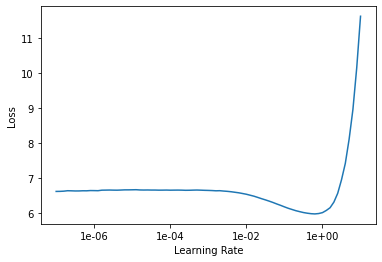

In [30]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [31]:
#learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.092097,3.891059,0.348638,00:06


In [32]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-2,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.849155,3.587955,0.393828,00:08
1,3.563683,3.441224,0.426284,00:08
2,3.298337,3.389484,0.437589,00:08
3,2.953006,3.401960,0.448181,00:08
4,2.664491,3.464551,0.444978,00:08
5,2.347411,3.633534,0.446060,00:08
6,2.065163,3.783778,0.443002,00:08
7,1.815096,3.900844,0.442478,00:08
8,1.557496,4.020628,0.445000,00:08
9,1.310456,4.105060,0.449196,00:08


In [33]:
learn.predict('Help us. There has been a flooding',n_words=10)

'Help us. There has been a flooding in Calgary . Please help my family and'

In [34]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

## Classification

In [35]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('', train_df=df_train, valid_df=df_test, vocab=data_lm.train_ds.vocab, min_freq=1,bs=32)
data_clas.save()

In [36]:
# Classifier
classifier = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.5)
classifier.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (7692 items)
x: TextList
xxbos @astrodamo ah it was a non - event really,xxbos xxmaj holy fuck me in the ass the water just keeps rising http : / / t.co / mib8v5kk,xxbos xxmaj we got kicked out of the backyard cuz one kid gets too excited and is too loud,xxbos xxmaj at stamps game . xxmaj do n't use this bucket . # yycflood fundraiser . http : / / t.co / ls3wkvt6bb,xxbos @travkus : xxmaj north xxmaj sask xxmaj river expected to rise 3.5 metres by xxmaj saturday . xxmaj city of xxmaj edmonton under xxmaj flood xxmaj watch . # abflood # yeg
y: CategoryList
0,1,0,1,1
Path: .;

Valid: LabelList (3297 items)
x: TextList
xxbos xxmaj latest on the xxmaj queensland flood crisis can be found here : http : / / t.co / ykvps8th # sun7 # qldfloods # bigwet,xxbos xxmaj love that xxmaj jay xxmaj feaster gave a shout out to the flood victims of xxmaj southern xxmaj alberta @nhlflames # nhldraft # calgarystrong # calgaryflood,xxbos i think i 'm tired

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


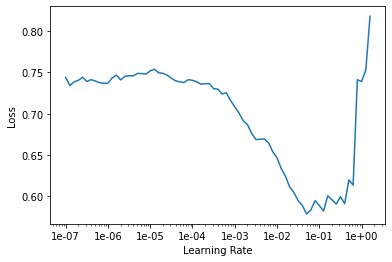

In [37]:
classifier.lr_find(start_lr=1e-8, end_lr=1e2)
classifier.recorder.plot()

In [38]:
classifier.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.338215,0.228857,0.914771,00:06


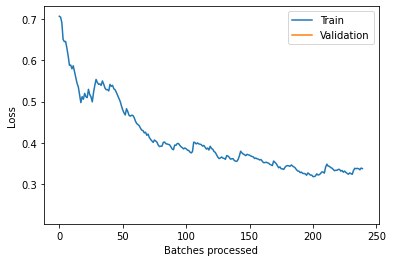

In [39]:
classifier.recorder.plot_losses()

In [40]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.306125,0.206033,0.933879,00:07


In [41]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.243107,0.193614,0.937519,00:09


In [42]:
classifier.unfreeze()
classifier.fit_one_cycle(5, slice(1e-5,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.224203,0.196787,0.941159,00:12
1,0.204051,0.188755,0.951471,00:12
2,0.127397,0.228274,0.949348,00:12
3,0.101319,0.175343,0.950561,00:12
4,0.068700,0.202373,0.951774,00:13


In [59]:

# Save the entire model as a SavedModel.
classifier.save('saved_models2/ULMFiT') 

FileNotFoundError: ignored

In [62]:
from google.colab import files

torch.save(classifier,'filename2.pth')
files.download('filename2.pth')



AttributeError: ignored

In [56]:
# my_model directory
!ls 

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/data_lm

adc.json       Filename.csv  sample_data  saved_models	train.csv
data_save.pkl  models	     saved_model  test.csv
saved_model/data_lm


In [60]:
new_model =  torch.load('models/ULMFiT')

# Check its architecture
new_model.summary()

FileNotFoundError: ignored

In [44]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_images).shape)

NameError: ignored


Confusion matrix
Accuracy: 0.9517743403093721
Precision:  0.9638616417139907
Recall:  0.9544989775051125


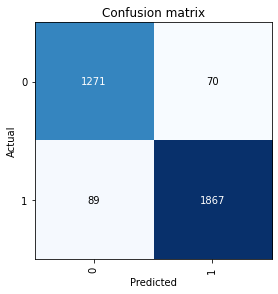

In [45]:
# get predictions
preds, targets,losses = classifier.get_preds(with_loss=True)
interp =ClassificationInterpretation(classifier,preds, targets, losses)
interp.plot_confusion_matrix()
#predictions = np.argmax(preds, axis=1)
#pd.crosstab(predictions, targets)


print('\nConfusion matrix')
conf_mat = interp.confusion_matrix()
TN =conf_mat[0][0]
FP =conf_mat[0][1]
FN =conf_mat[1][0]
TP =conf_mat[1][1]

acc = (TP+TN)/(TP+TN+FP+FN)
prec = TP/(TP+FP)
rec = TP/(TP+FN)
print('Accuracy:',(acc))
print('Precision: ', prec)
print('Recall: ', rec)

In [46]:
df_test['text'][:10].apply(lambda row: str(classifier.predict(row)[0]))

1946     1
10735    1
1899     1
6104     1
1294     0
7750     0
597      0
9955     1
5849     0
2513     1
Name: text, dtype: object